In [ ]:
# 1. Initialize Client and Load Data

import pandas as pd
import numpy as np
from agentds import BenchmarkClient

# 🔑 REPLACE WITH YOUR CREDENTIALS
client = BenchmarkClient(
    api_key="your-api-key-here",        # Get from your team dashboard
    team_name="your-team-name-here"     # Your exact team name
)

print("📂 Loading Manufacturing Challenge 1 data...")

# Load sensor readings data
train_sensors = pd.read_csv("../datasets/sensor_readings_train.csv", parse_dates=["timestamp"])
test_sensors = pd.read_csv("../datasets/sensor_readings_test.csv", parse_dates=["timestamp"])

print(f"✅ Data loaded:")
print(f"   Train sensors: {train_sensors.shape}")
print(f"   Test sensors: {test_sensors.shape}")

📂 Loading Manufacturing Challenge 1 data...
✅ Data loaded:
   Train sensors: (131050, 6)
   Test sensors: (131050, 5)


In [124]:
prod_logs = pd.read_json("../datasets/production_logs.json")
op_logs = pd.read_json("../datasets/operator_logs.json")

In [125]:
def assign_shift(hour):
    if 0 <= hour < 8:
        return 1
    elif 8 <= hour < 16:
        return 2
    else:
        return 3

In [126]:
train_sensors["timestamp"] = pd.to_datetime(train_sensors["timestamp"])
test_sensors["timestamp"] = pd.to_datetime(test_sensors["timestamp"])

train_sensors["shift"] = train_sensors["timestamp"].dt.hour.apply(assign_shift)
train_sensors["date"] = train_sensors["timestamp"].dt.date

test_sensors["shift"] = test_sensors["timestamp"].dt.hour.apply(assign_shift)
test_sensors["date"] = test_sensors["timestamp"].dt.date


In [127]:
prod_logs["date"] = pd.to_datetime(prod_logs["date"]).dt.date
op_logs["date"] = pd.to_datetime(op_logs["date"]).dt.date

In [128]:
prod_logs['delay_flag'] = prod_logs["log_text"].str.contains("delayed", case=False).astype(int)
prod_logs['failure_flag'] = prod_logs["log_text"].str.contains(r"\b(failure|stoppage|freeze|emergency|intervention)\b", case=False).astype(int)

op_logs['op_normal_flag'] = op_logs["log_text"].str.contains(r"\b(normally|smoothly|operating)\b", case=False).astype(int)

/var/folders/22/d3vg34ps7016f1vrkgzqcj_00000gn/T/ipykernel_45969/106121764.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  prod_logs['failure_flag'] = prod_logs["log_text"].str.contains(r"\b(failure|stoppage|freeze|emergency|intervention)\b", case=False).astype(int)
/var/folders/22/d3vg34ps7016f1vrkgzqcj_00000gn/T/ipykernel_45969/106121764.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  op_logs['op_normal_flag'] = op_logs["log_text"].str.contains(r"\b(normally|smoothly|operating)\b", case=False).astype(int)


In [129]:
prod_logs = prod_logs[['machine_id', 'date', 'shift', 'delay_flag', 'failure_flag']]
op_logs = op_logs[['machine_id', 'date', 'shift', 'op_normal_flag']]

In [ ]:
train = train_sensors.merge(prod_logs, on=["machine_id", "date", "shift"], how="left")
train = train.merge(op_logs, on=["machine_id", "date", "shift"], how="left")

test = test_sensors.merge(prod_logs, on=["machine_id", "date", "shift"], how="left")
test = test.merge(op_logs, on=["machine_id", "date", "shift"], how="left")

In [132]:
target = "failure_24h"
features = [c for c in train.columns if c not in ["timestamp", "machine_id", "date", "shift", target]]

In [133]:
X_train = train[features]
y_train = train[target]
X_test = test[features]

In [134]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb

In [139]:
from itertools import product
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import random

# --- GroupKFold setup ---
groups = train["machine_id"].values
gkf = StratifiedGroupKFold(n_splits=5)

# --- Parameter grid ---

param_grid = {
  "num_leaves": [8, 15, 32],
  "max_depth": [3, 4],
  "min_data_in_leaf": [40, 60, 80],
  "feature_fraction": [0.8, 0.9, 1.0],
  "bagging_fraction": [0.8, 0.9],
  "lambda_l1": [0.05, 0.1, 0.15],
  "lambda_l2": [0.4, 0.5, 0.6],
}

param_combos = list(product(*param_grid.values()))

best_score = float("inf")
best_params = None

param_combos = random.sample(param_combos, 30)

# --- Start tuning ---
for combo in tqdm(param_combos, desc="Tuning LGBM (MSE)"):
    params = dict(zip(param_grid.keys(), combo))
    params.update({
        "objective": "binary",       
        "metric": 'binary_logloss',
        "verbose": -1,
        "seed": 42,
        "n_estimators": 1000,
        "learning_rate": 0.01
    })

    fold_scores = []

    for tr_idx, val_idx in gkf.split(X_train, y_train, groups):  # Use original (non-log) target
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="binary_logloss",
        )

        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average="macro")
        fold_scores.append(f1)

    mean_f1 = np.mean(fold_scores)

    print(f"{params} => f1: {mean_f1:.6f}")
    if mean_f1 < best_score:
        best_score = mean_f1
        best_params = params

print("\n✅ Best params:", best_params)
print("✅ Best mean f1:", best_score)


Tuning LGBM (MSE):   3%|▎         | 1/30 [00:10<04:55, 10.19s/it]

{'num_leaves': 32, 'max_depth': 4, 'min_data_in_leaf': 60, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l1': 0.15, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990490


Tuning LGBM (MSE):   7%|▋         | 2/30 [00:17<04:02,  8.66s/it]

{'num_leaves': 15, 'max_depth': 3, 'min_data_in_leaf': 80, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 0.1, 'lambda_l2': 0.4, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990561


Tuning LGBM (MSE):  10%|█         | 3/30 [00:27<04:03,  9.01s/it]

{'num_leaves': 32, 'max_depth': 4, 'min_data_in_leaf': 60, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'lambda_l1': 0.15, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990621


Tuning LGBM (MSE):  13%|█▎        | 4/30 [00:34<03:38,  8.42s/it]

{'num_leaves': 15, 'max_depth': 3, 'min_data_in_leaf': 80, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'lambda_l1': 0.05, 'lambda_l2': 0.4, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990561


Tuning LGBM (MSE):  17%|█▋        | 5/30 [00:42<03:21,  8.05s/it]

{'num_leaves': 32, 'max_depth': 3, 'min_data_in_leaf': 60, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990541


Tuning LGBM (MSE):  20%|██        | 6/30 [00:51<03:23,  8.48s/it]

{'num_leaves': 32, 'max_depth': 4, 'min_data_in_leaf': 80, 'feature_fraction': 1.0, 'bagging_fraction': 0.9, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990619


Tuning LGBM (MSE):  23%|██▎       | 7/30 [00:58<03:07,  8.17s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 80, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 0.15, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990470


Tuning LGBM (MSE):  27%|██▋       | 8/30 [01:07<03:05,  8.42s/it]

{'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 80, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'lambda_l1': 0.05, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990620


Tuning LGBM (MSE):  30%|███       | 9/30 [01:18<03:08,  8.99s/it]

{'num_leaves': 32, 'max_depth': 4, 'min_data_in_leaf': 60, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'lambda_l1': 0.15, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990490


Tuning LGBM (MSE):  33%|███▎      | 10/30 [01:25<02:50,  8.53s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 80, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l1': 0.15, 'lambda_l2': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990561


Tuning LGBM (MSE):  37%|███▋      | 11/30 [01:35<02:51,  9.03s/it]

{'num_leaves': 15, 'max_depth': 4, 'min_data_in_leaf': 80, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990605


Tuning LGBM (MSE):  40%|████      | 12/30 [01:43<02:34,  8.58s/it]

{'num_leaves': 32, 'max_depth': 3, 'min_data_in_leaf': 60, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'lambda_l1': 0.1, 'lambda_l2': 0.4, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990385


Tuning LGBM (MSE):  43%|████▎     | 13/30 [01:52<02:30,  8.85s/it]

{'num_leaves': 15, 'max_depth': 4, 'min_data_in_leaf': 60, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990621


Tuning LGBM (MSE):  47%|████▋     | 14/30 [02:02<02:23,  9.00s/it]

{'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 60, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 0.05, 'lambda_l2': 0.4, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990534


Tuning LGBM (MSE):  50%|█████     | 15/30 [02:12<02:20,  9.35s/it]

{'num_leaves': 15, 'max_depth': 4, 'min_data_in_leaf': 60, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 0.05, 'lambda_l2': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990514


Tuning LGBM (MSE):  53%|█████▎    | 16/30 [02:19<02:03,  8.80s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 40, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l1': 0.15, 'lambda_l2': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990566


Tuning LGBM (MSE):  57%|█████▋    | 17/30 [02:28<01:55,  8.87s/it]

{'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 40, 'feature_fraction': 1.0, 'bagging_fraction': 0.9, 'lambda_l1': 0.1, 'lambda_l2': 0.4, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990579


Tuning LGBM (MSE):  60%|██████    | 18/30 [02:36<01:41,  8.47s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 60, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 0.05, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990475


Tuning LGBM (MSE):  63%|██████▎   | 19/30 [02:43<01:29,  8.15s/it]

{'num_leaves': 32, 'max_depth': 3, 'min_data_in_leaf': 60, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'lambda_l1': 0.05, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990589


Tuning LGBM (MSE):  67%|██████▋   | 20/30 [02:51<01:19,  7.97s/it]

{'num_leaves': 15, 'max_depth': 3, 'min_data_in_leaf': 40, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'lambda_l1': 0.05, 'lambda_l2': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990539


Tuning LGBM (MSE):  70%|███████   | 21/30 [03:00<01:15,  8.40s/it]

{'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 80, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990647


Tuning LGBM (MSE):  73%|███████▎  | 22/30 [03:08<01:05,  8.14s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 40, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l1': 0.1, 'lambda_l2': 0.4, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990494


Tuning LGBM (MSE):  77%|███████▋  | 23/30 [03:18<01:01,  8.75s/it]

{'num_leaves': 32, 'max_depth': 4, 'min_data_in_leaf': 40, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'lambda_l1': 0.15, 'lambda_l2': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990332


Tuning LGBM (MSE):  80%|████████  | 24/30 [03:28<00:55,  9.18s/it]

{'num_leaves': 32, 'max_depth': 4, 'min_data_in_leaf': 60, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'lambda_l1': 0.15, 'lambda_l2': 0.4, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990561


Tuning LGBM (MSE):  83%|████████▎ | 25/30 [03:38<00:46,  9.25s/it]

{'num_leaves': 32, 'max_depth': 4, 'min_data_in_leaf': 40, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'lambda_l1': 0.15, 'lambda_l2': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990554


Tuning LGBM (MSE):  87%|████████▋ | 26/30 [03:48<00:38,  9.55s/it]

{'num_leaves': 15, 'max_depth': 4, 'min_data_in_leaf': 40, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'lambda_l1': 0.1, 'lambda_l2': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990514


Tuning LGBM (MSE):  90%|█████████ | 27/30 [03:57<00:28,  9.38s/it]

{'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 40, 'feature_fraction': 1.0, 'bagging_fraction': 0.9, 'lambda_l1': 0.05, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990513


Tuning LGBM (MSE):  93%|█████████▎| 28/30 [04:04<00:17,  8.83s/it]

{'num_leaves': 8, 'max_depth': 3, 'min_data_in_leaf': 60, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l1': 0.1, 'lambda_l2': 0.5, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990498


Tuning LGBM (MSE):  97%|█████████▋| 29/30 [04:14<00:08,  9.00s/it]

{'num_leaves': 8, 'max_depth': 4, 'min_data_in_leaf': 60, 'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'lambda_l1': 0.1, 'lambda_l2': 0.4, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990489


Tuning LGBM (MSE): 100%|██████████| 30/30 [04:21<00:00,  8.72s/it]

{'num_leaves': 15, 'max_depth': 3, 'min_data_in_leaf': 80, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'lambda_l1': 0.1, 'lambda_l2': 0.4, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01} => f1: 0.990660

✅ Best params: {'num_leaves': 32, 'max_depth': 4, 'min_data_in_leaf': 40, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'lambda_l1': 0.15, 'lambda_l2': 0.6, 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1, 'seed': 42, 'n_estimators': 1000, 'learning_rate': 0.01}
✅ Best mean f1: 0.9903316387964903


In [ ]:
final_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=15,
    max_depth=3,
    min_data_in_leaf=80,
    feature_fraction=1.0,
    bagging_fraction=0.8,
    lambda_l1=0.1,
    lambda_l2=0.4,
    verbose=-1,
    random_state=42
)

final_model.fit(
    X_train,
    y_train,
    eval_metric="binary_logloss",
)

,boosting_type,'gbdt'
,num_leaves,15
,max_depth,3
,learning_rate,0.01
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


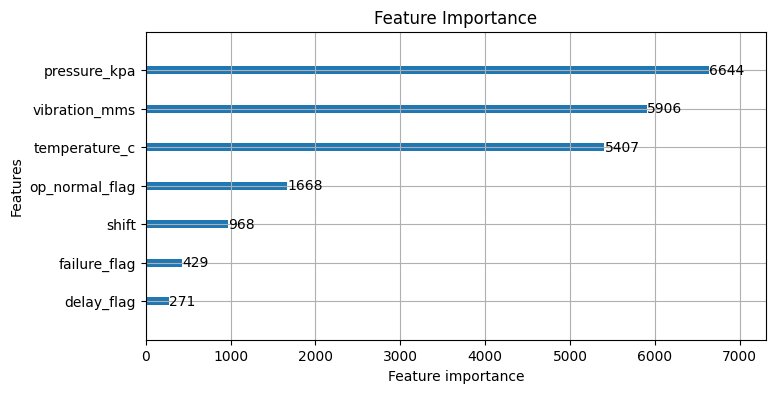

In [15]:
import matplotlib.pyplot as plt
lgb.plot_importance(final_model, figsize=(8, 4), max_num_features=10)
plt.title("Feature Importance")
plt.show()

In [141]:
predictions = final_model.predict(X_test)

In [142]:
train_sensors = pd.read_csv("../datasets/sensor_readings_train.csv")
test_sensors = pd.read_csv("../datasets/sensor_readings_test.csv")

In [143]:
submission_df = pd.DataFrame({
    'timestamp': test_sensors['timestamp'],
    'machine_id': test_sensors['machine_id'],
    'failure_24h': predictions
})

submission_df.to_csv("manufacturing_challenge1_predictions.csv", index=False)
print(f"✅ Predictions saved: {submission_df.shape[0]} predictions")
print(f"   Preview: {submission_df.head(3)}")
print(f"   Failure rate: {predictions.mean():.3f} ({predictions.sum()} failures out of {len(predictions)})")

✅ Predictions saved: 131050 predictions
   Preview:               timestamp machine_id  failure_24h
0  2025-01-01T00:00:00Z    MCH_002            0
1  2025-01-01T00:00:00Z    MCH_004            0
2  2025-01-01T00:00:00Z    MCH_005            0
   Failure rate: 0.086 (11299 failures out of 131050)


In [144]:
# 3. Submit Predictions

# Submit predictions to the competition
print("🚀 Submitting predictions...")

try:
    result = client.submit_prediction("Manufacturing", 1, "manufacturing_challenge1_predictions.csv")
    
    if result['success']:
        print("✅ Submission successful!")
        print(f"   📊 Score: {result['score']:.4f}")
        print(f"   📏 Metric: {result['metric_name']}")
        print(f"   ✔️  Validation: {'Passed' if result['validation_passed'] else 'Failed'}")
    else:
        print("❌ Submission failed!")
        print(f"   Error details: {result.get('details', {}).get('validation_errors', 'Unknown error')}")
        
except Exception as e:
    print(f"💥 Submission error: {e}")
    print("🔧 Check your API key and team name are correct!")

print("\n🎯 Next steps:")
print("   1. Try incorporating operator_logs.json text data")
print("   2. Engineer time-based features from timestamps")
print("   3. Move on to Manufacturing Challenge 2 (quality cost)!")

🚀 Submitting predictions...
✅ Prediction submitted successfully!
📊 Score: 0.9909 (Macro-F1)
✅ Validation passed
✅ Submission successful!
   📊 Score: 0.9909
   📏 Metric: Macro-F1
   ✔️  Validation: Passed

🎯 Next steps:
   1. Try incorporating operator_logs.json text data
   2. Engineer time-based features from timestamps
   3. Move on to Manufacturing Challenge 2 (quality cost)!
